In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import pearsonr
from datetime import datetime
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%b")  # Format: Jan-2023

In [ ]:
""" Helper functions for Strava API and plotting"""
import requests
import urllib3
from matplotlib.ticker import FuncFormatter


# Function to get Strava activity data
def get_strava_activity_data(ACCESS_TOKEN, url="https://www.strava.com/api/v3/activities"):
    """ Obtain all activities from strava"""
    
    header = {'Authorization': 'Bearer ' + ACCESS_TOKEN}  # access_token = strava_tokens['access_token']
    
    # Run parameter columns
    columns = ["id", "name", "external_id",
                "start_date_local",
                "type", 'sport_type',
                "distance", "moving_time", "elapsed_time",
                "total_elevation_gain",
                'start_latlng', "end_latlng",            
                'average_speed', 'max_speed',
                'has_heartrate', 'average_heartrate',
                'suffer_score',
                
    ]
    # Create the dataframe to store API-returned activity data
    activities = pd.DataFrame(columns=columns)

    # Loop across pages + loop across columns! except for map-summary_polyline
    page = 1
    pp = 200  # entries per page
    while True:
        param = {'per_page': pp, 'page': page}      # get page of activities from Strava
        r = requests.get(url, headers=header, params=param).json()
        if (not r):  # if no results then exit loop
            break
        # otherwise add new data to dataframe
        for x in range(len(r)):
            if (r[x]["has_heartrate"]):
                for col in columns:
                    activities.loc[x + (page-1)*pp, col] = r[x][col]
                    
        page += 1  # increment page
        
    print(f"{len(activities)} activities obtained from Strava API")
    return activities



def get_strava_refresh_access_token():
    """ GET REFRESH TOKEN FOR API """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    auth_url = "https://www.strava.com/oauth/token"

    payload = {
        'client_id': xxx,
        'client_secret': 'xxx',
        'refresh_token': 'xxx',
        'grant_type': "refresh_token",
        'f': 'json'
    }

    # Request token
    res = requests.post(auth_url, data=payload, verify=False)
    return res.json()['access_token']


def get_activity_by_id(activity_id, ACCESS_TOKEN):
    url = f"https://www.strava.com/api/v3/activities/{activity_id}"
    headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching activity {activity_id}: {response.status_code}")
        print(response.text)
        return None



def apply_pace_labels(ax, min_pace="5:00", max_pace="10:00", step="0:30", axis="y"):
    """
    Apply `min:sec` pace labeling to the specified axis.

    Parameters:
    - ax: matplotlib axis object to apply labels to.
    - min_pace: Starting pace as a string in "min:sec" format (e.g., "5:00").
    - max_pace: Ending pace as a string in "min:sec" format (e.g., "10:00").
    - step: Step size for the ticks as a string in "min:sec" format (e.g., "0:30").
    - axis: The axis to apply the labels to ("x" or "y").
    """
    # Convert parameters to timedelta and calculate tick positions
    min_seconds = pd.to_timedelta(f"00:{min_pace}").total_seconds()
    max_seconds = pd.to_timedelta(f"00:{max_pace}").total_seconds()
    step_seconds = pd.to_timedelta(f"00:{step}").total_seconds()
    ticks = list(range(int(min_seconds), int(max_seconds) + 1, int(step_seconds)))

    # Apply to the correct axis
    if axis == "y":
        ax.set_yticks(ticks)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x // 60)}:{int(x % 60):02d}"))
    elif axis == "x":
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x // 60)}:{int(x % 60):02d}"))
    else:
        raise ValueError("Axis must be 'x' or 'y'.")



In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# DATA folder
os.makedirs("./data", exist_ok=True)

# Figure params
SAVE_FIGURE = True
results_save_path = "./results/runs-overview-0725/"
os.makedirs(results_save_path, exist_ok=True) if SAVE_FIGURE else None
fdict = dict(fname=f"", dpi=600, bbox_inches="tight", edgecolor=None)

# Compound figure folder
compound_figure_path = "./results/compound-figures-0725/"
os.makedirs(compound_figure_path, exist_ok=True) if SAVE_FIGURE else None

# Convert Metrics


In [4]:
# Get access token
ACCESS_TOKEN = get_strava_refresh_access_token()

# Get all activities
activities = get_strava_activity_data(ACCESS_TOKEN)

# from meters to kilometers
df = activities.copy()
df = df[df["distance"] > 0]  
df['distance'] = (df['distance'] / 1000).round(2)

# Filter out low distance (also makes sure no division by zero, filters out Stepper etc.)
dist_thres = 3.0 # distance threshold in km
df = df[df["distance"] > dist_thres]  
print(f"{len(df)} activities left after filtering out < {dist_thres} km")

# from seconds to minutes
df['moving_time_min'] = np.round(df['moving_time'] / 60, 2)

# Fix start_date column into the correct format and set as index
df["start_date_local"] = pd.to_datetime(df['start_date_local'])
df.set_index("start_date_local", inplace=True)

# Change from m/s to km/h
df['max_speed'] = df['max_speed'] * 3.6
df['average_speed'] = df['average_speed'] * 3.6

# Calculate pace and transfer to seconds (for plotting mm:ss)
df['pace'] = df['moving_time_min'] / df['distance']
df["pace_sec"] = pd.to_timedelta(df["pace"] * 60, unit="s").dt.total_seconds()

# Save resulting df to csv
today = datetime.now().strftime('%d-%m-%Y')
spath = f"./data/strava_activities_overview_{today}.csv"
df.to_csv(spath, index=False)
print(f"saved data to {spath}")

# types of sport recorded
print(f"activity type: {df.type.unique()} \nactivity SPORT type: {df.sport_type.unique()}")
print(f"number of runs: {len(df[df.type.isin(['Run'])])}")

# Select Runs and TrailRuns
df_allruns = df[df.type.isin(["Run"])]
df_allruns = df_allruns[(df_allruns.index.year >= 2025)]

# Add pace in seconds
df_allruns["pace_sec"] = pd.to_timedelta(df_allruns["pace"] * 60, unit="s").dt.total_seconds()

# Progress
corr_coef, p_value = pearsonr(np.arange(len(df_allruns["pace"])), df_allruns["pace_sec"])
print(f"Pace vs Runs, Pearsons R: {np.round(corr_coef,3)} and p-val: {p_value: .2e}")
df_allruns = df_allruns[1:]

986 activities obtained from Strava API
708 activities left after filtering out < 3.0 km
saved data to ./data/strava_activities_overview_02-07-2025.csv
activity type: ['Run' 'Ride' 'Walk' 'Hike' 'Workout'] 
activity SPORT type: ['Run' 'Ride' 'Walk' 'Hike' 'TrailRun' 'GravelRide' 'Workout']
number of runs: 366
Pace vs Runs, Pearsons R: -0.32 and p-val:  5.88e-04


In [5]:
df_allruns

,id,name,external_id,type,sport_type,distance,moving_time,elapsed_time,total_elevation_gain,start_latlng,end_latlng,average_speed,max_speed,has_heartrate,average_heartrate,suffer_score,moving_time_min,pace,pace_sec
start_date_local,,,,,,,,,,,,,,,,,,,
2025-06-30 13:28:05+00:00,14961815301,Neue Schuhe testen,garmin_ping_454287155230,Run,Run,6.2691,2603,2665,31.4,"[50.120232, 8.646006]","[50.123509, 8.650154]",8.6688,23.328,True,139.4,23.0,43.383333,6.920185,415.211115
2025-06-30 06:27:25+00:00,14959312785,Rekom nüchtern,garmin_ping_454203878241,Run,Run,9.7843,4064,4102,16.5,"[50.121615, 8.647797]","[50.121627, 8.647706]",8.6688,15.624,True,125.5,15.0,67.733333,6.922655,415.359300
2025-06-29 07:29:34+00:00,14948672077,Rekom nüchtern,garmin_ping_453870877514,Run,Run,7.2394,3110,3125,35.5,"[50.12004, 8.646295]","[50.121772, 8.648275]",8.3808,17.424,True,123.7,11.0,51.833333,7.159894,429.593613
2025-06-28 09:06:50+00:00,14938900219,Morning Run,garmin_ping_453572349711,Run,Run,3.6694,1093,1093,2.1,"[50.141533, 8.640222]","[50.148531, 8.633827]",12.0852,16.2,True,141.0,7.0,18.216667,4.964481,297.868861
2025-06-27 08:15:23+00:00,14929428492,Rekom nüchtern,garmin_ping_453245469576,Run,Run,6.1112,2509,2509,2.1,"[50.141156, 8.639951]","[50.139216, 8.638698]",8.7696,13.968,True,125.4,9.0,41.816667,6.842628,410.557665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 12:02:42+00:00,13289723183,Lunch Run,garmin_ping_400250462990,Run,Run,17.5369,6750,6752,34.4,"[50.119843, 8.64565]","[50.121319, 8.647826]",9.3528,18.0,True,153.0,141.0,112.5,6.415045,384.902691
2025-01-06 14:18:54+00:00,13281803043,Afternoon Run,garmin_ping_399978656554,Run,Run,17.6591,7337,7644,68.9,"[50.119995, 8.645808]","[50.121727, 8.648358]",8.6652,17.28,True,146.3,85.0,122.283333,6.924664,415.479838
2025-01-04 17:25:08+00:00,13266191638,Afternoon Run,garmin_ping_399424175242,Run,Run,6.5628,2919,2919,0,[],[],8.0928,14.688,True,147.6,44.0,48.65,7.412994,444.779667


In [6]:
# Resample Distance per run
col = 'distance'
# Weekly
period = "W"#-MON"
runs_weeks_dist = df_allruns.resample(period)[col].sum() # sum distance
# Monthly
period = "MS"
runs_months_dist = df_allruns.resample(period)[col].sum()
# Daily
period = "D"
runs_days_dist = df_allruns.resample(period)[col].sum()

# Resample Pace per run
col = "pace_sec"
# 2 weeks
period = "2W-MON"
runs_2weeks_pace = df_allruns.resample(period)[col].median()
# Daily
period = "D"
runs_days_pace = df_allruns.resample(period)[col].mean()  # mean pace
# Rolling window
twindow = "14D"
min_periods = 1
pace_rollingx = runs_days_pace.rolling(window=twindow, min_periods=min_periods).median().index
pace_rollingy = runs_days_pace.rolling(window=twindow, min_periods=min_periods).median().values

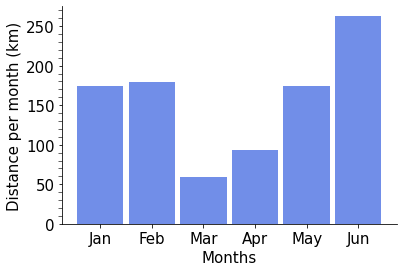

In [7]:
month_lengths = runs_months_dist.index.to_series().dt.days_in_month - 1
xtick_positions = runs_months_dist.index + pd.to_timedelta(month_lengths // 2, unit="D")
date_xlim = (pd.Timestamp(df_allruns.index[-1]) - pd.Timedelta(days=7), pd.Timestamp(df_allruns.index[0]) + pd.Timedelta(days=7))
x = np.arange(0, len(runs_months_dist.index))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x, runs_months_dist.values, width=.9, alpha=.75, label="Monthly", fill=True, color="royalblue", edgecolor=None, align='center')
ax.tick_params(axis='y', which='minor', length=4)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set(ylabel="Distance per month (km)", ylim=[0, 275], xlabel="Months"); # 
ax.set_xticks(ticks=x, labels=runs_months_dist.index.strftime("%b"), rotation=0);


fdict["fname"] = f"{results_save_path}/summed_distance-per-month.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

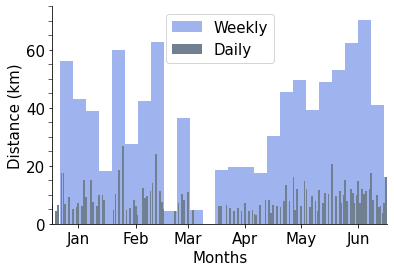

In [8]:
# Distance per run binning
longest_week = 75
x = np.arange(0, len(runs_months_dist.index))

# Plotting
fdict["fname"] = f"{results_save_path}/daily-and-summed-distance-per-run-timeline-2025-onwards.jpg"
ax_params = dict(ylabel="Distance (km)", ylim=(0,longest_week), yticks=range(0, longest_week+1, 20),
                 xlabel="Months", xlim=(pd.Timestamp("2025-01-01"), df_allruns.index[0]))  # pd.Timestamp("2025-04-12")

fig, ax = plt.subplots(figsize=(6,4))
ax.stairs(list(runs_weeks_dist.values)[1:], runs_weeks_dist.index, alpha=.5, label="Weekly", fill=True, color="royalblue", edgecolor=None)
ax.bar(runs_days_dist.index, runs_days_dist.values, width=.9, color="slategray", label="Daily")
# Axes stuff
ax.set_xticks(ticks=[x+14 for x in ax.get_xticks()], labels=ax.get_xticklabels(), rotation=0);

ax.tick_params(axis='y', which='minor', length=4)
ax.set(**ax_params)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_formatter(date_format)
ax.legend(loc="upper center");
fig.savefig(**fdict) if SAVE_FIGURE else None

# pace_sec

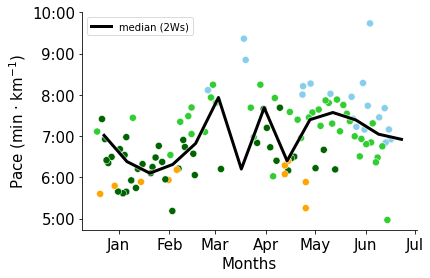

In [9]:
# Define heart rate zones and labels
hr_zones_ = [(0, 128), (129, 144), (145, 159), (160, 167), (168, 175), (176, 183), (184, 191), (192, 197)]
hr_zone_labels_ = ["Endurance", "Low-Moderate", "High-Moderate", "Low-Tempo", "High-Tempo", "Low-Threshold", "High-Threshold", "Anaerobic"]
hr_zone_colors = ["skyblue", "limegreen", "darkgreen", "orange", "darkorange", "orangered", "red", "darkred"]

# Bin heart rate into zones with labels
df_allruns["hr_zone_color"] = pd.cut(df_allruns["average_heartrate"], bins=[z[0] for z in hr_zones_] + [hr_zones_[-1][1]], labels=hr_zone_colors)

# Plotting
pace_labels = dict(min_pace="5:00", max_pace="10:00", step="1:00", axis="y")

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(runs_2weeks_pace.index, runs_2weeks_pace.values, "-", lw=5, alpha=.5, color="white")
ax.plot(runs_2weeks_pace.index, runs_2weeks_pace.values, "-", lw=3, alpha=1, color="k", label="median (2Ws)")
ax.scatter(df_allruns.index, df_allruns["pace_sec"], c=df_allruns["hr_zone_color"], s=50, alpha=1, edgecolors="w", linewidths=.5)

# Axes stuff
ax.set_xticks(ticks=[x+14 for x in ax.get_xticks()], labels=ax.get_xticklabels(), rotation=0);
ax.xaxis.set_major_formatter(date_format)
apply_pace_labels(ax, **pace_labels)
ax.set(ylabel="Pace (min · km$^{-1}$)", xlabel="Months");
ax.legend(fontsize=10, loc="upper left", frameon=True, framealpha=.7); #, boxalpha=0.8

fdict["fname"] = f"{results_save_path}/pace-progression-2W-window-2025.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

[20103. 20134. 20162. 20193. 20223. 20254. 20284.]


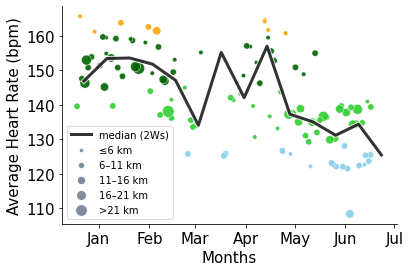

In [10]:
# Define marker sizes based on distance ranges
legend_sizes = [20, 40, 70, 100, 140]
marker_sizes = []
for dist in df_allruns["distance"]:
    if dist <= 6:
        marker_sizes.append(legend_sizes[0])
    elif 6 < dist <= 11:
        marker_sizes.append(legend_sizes[1])
    elif 11 < dist <= 16:
        marker_sizes.append(legend_sizes[2])
    elif 16 < dist <= 21:
        marker_sizes.append(legend_sizes[3])
    else:
        marker_sizes.append(legend_sizes[4])

#legend_sizes = [30, 60, 100, 150, 200]
labels = ["≤6 km", "6–11 km", "11–16 km", "16–21 km", ">21 km"]

# Resample Heart Rate per run
period = "2W-MON"
col = 'average_heartrate'
runs_2weeks_hr = df_allruns.resample(period)[col].median()
# Daily
period = "D"
runs_daily_hr = df_allruns.resample(period)[col].mean()  # mean HR
twindow = "14D"
min_periods = 1
hrrollingx = runs_daily_hr.rolling(window=twindow, min_periods=min_periods).median().index
hrrollingy = runs_daily_hr.rolling(window=twindow, min_periods=min_periods).median().values

# Plotting
fdict["fname"] = f"{results_save_path}/heart-rate-progression-hrzone-colored.jpg"

fig, ax = plt.subplots(figsize=(6,4))
#ax.plot(hrrollingx, hrrollingy, "-", color="w", lw=2, alpha=.8)
#ax.plot(hrrollingx, hrrollingy, "-", color="royalblue", lw=1, alpha=.8, label="rolling m. (2Ws)")
ax.plot(runs_2weeks_hr.index, runs_2weeks_hr.values, "-", lw=5, alpha=.8, color="white")
ax.plot(runs_2weeks_hr.index, runs_2weeks_hr.values, "-", lw=3, alpha=.8, color="k", label="median (2Ws)")
ax.scatter(df_allruns.index, df_allruns["average_heartrate"], s=marker_sizes, c=df_allruns["hr_zone_color"], alpha=.9, edgecolors="w", linewidths=.5)

for size, label in zip(legend_sizes, labels):
    ax.scatter([], [], s=size, alpha=0.9, c="slategray", edgecolors="w", label=label)

ax.set_xticks(ticks=[x+14 for x in ax.get_xticks()], labels=ax.get_xticklabels(), rotation=0);
print(ax.get_xticks())
ax.set(ylabel="Average Heart Rate (bpm)", xlabel="Months")
ax.xaxis.set_major_formatter(date_format)
ax.legend(fontsize=10, loc="lower left", frameon=True, framealpha=.7); #, boxalpha=0.8

fig.savefig(**fdict) if SAVE_FIGURE else None

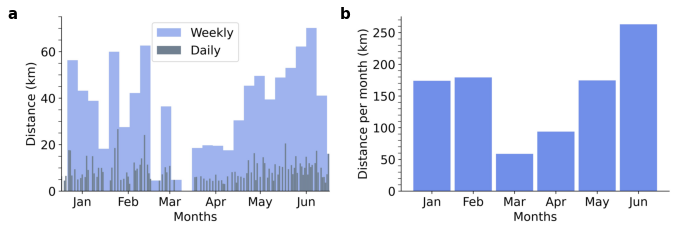

In [11]:
image_files = [
    f"{results_save_path}/daily-and-summed-distance-per-run-timeline-2025-onwards.jpg",
    f"{results_save_path}/summed_distance-per-month.jpg",
]

panel_labels = ["a", "b"]
fig_width = 12 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .01

fig, axes = plt.subplots(1, 2, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace})
for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-figure-1-a-to-b.jpg"
fdict["dpi"] = 600
fig.savefig(**fdict) if SAVE_FIGURE else None

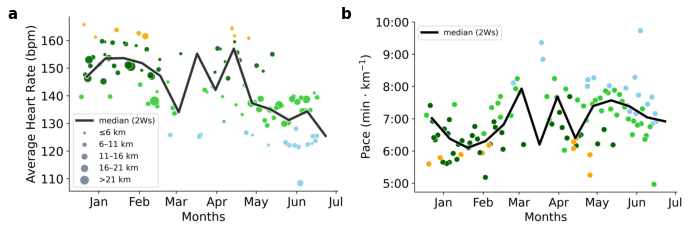

In [12]:
image_files = [
    f"{results_save_path}/heart-rate-progression-hrzone-colored.jpg",
    f"{results_save_path}/pace-progression-2W-window-2025.jpg",
]

panel_labels = ["a", "b"]

fig, axes = plt.subplots(1, 2, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace})
for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-figure-2-a-to-b.jpg"
fdict["dpi"] = 600
fig.savefig(**fdict) if SAVE_FIGURE else None

legend_text = r"""
Figure - Running progression. $\bf{a)}$ Progression of running pace over months of 2024. Individual runs are shown as gray circles, with size indicating the distance of each run. The median pace for 2-week periods is shown as a black line. The 7-day rolling median is shown as a thin blue line. $\bf{b)}$ Progression of heart rate over months of 2024. Individual runs are shown as circles, with color indicating the dominant heart rate zone of each run. The median heart rate as shown in (a).
Figure - Quantification of distance covered while running in 2024 and 2025. $\bf{a)}$ Probability distribution of distance per day / run and per week. $\bf{b)}$ Data in (a) plotted over time.
"""